
<div style="text-align: center; font-weight: bold;">
    <h1>Generating Research ready EHR Datasets</h1>
    <h2>Part 1: Accessing, Understanding and Summarizing EHR Data</h2>
    <h4>Author: Vidul Ayakulangara Panickan</h3>
</div>




**How the Tutorial is Structured**  

The tutorial is divided into three parts, split into three Python notebooks:  

Part 1: Accessing, Understanding, and Summarizing EHR Data  
Part 2: Cleaning, Organizing, and Rolling Up EHR Data  
Part 3: Aggregating the EHR Data to Create Analysis-Ready Data  

The tutorial is designed with clear steps that flow across all three parts, starting from Step 1 and continuing through to Step 6.  

If a step involves processing data, we will first go through the basic operations one by one. Then, we will create functions that perform these operations so they can be reused for processing other datasets in this tutorial.  

**Prerequisites:**  
1. Basic knowledge of Python programming
2. Access to MIMIC-IV 3.1 data
3. Harvard O2 account – running the tutorial on the O2 Cluster is recommended.  


## Gaining Access to MIMIC-IV Dataset

In this tutorial, we will work with MIMIC-IV dataset to showcase how to process EHR data. MIMIC-IV is a deidentified EHR dataset sourced from BIDMC Hospital. To gain access to MIMIC-IV, follow these steps

1. You will need to be a credentialed user. You can register in [here](https://physionet.org/register/) to create a physionet account and become a credential user
2. Complete the training listed [here](https://physionet.org/content/mimiciv/view-required-training/3.1/) and submit the trainings [here](https://physionet.org/settings/training/)
3. Sign the Data User Agreement [here](https://physionet.org/login/?next=/sign-dua/mimiciv/3.1/)

You will be notified via your registered email once the access is approved.

## Setting up your Compute Environment

### Working on O2 (Recommended)

We recommend using the Harvard O2 cluster for processing. After logging into your O2 account, you can execute the following commands on terminal and it should setup the workspace directory and subdirectories, download mimic data and install all the required libraries for you.

```bash
wget https://raw.githubusercontent.com/apvidul/bash_scripts/refs/heads/main/ehr_tutorial_setup.sh
sh ehr_tutorial_setup.sh
```


Once the above script finishes running,the EHR_TUTORIAL_WORKSPACE will be created with the following structure


```bash      
EHR_TUTORIAL_WORKSPACE/
├── raw_data         # The downloaded MIMIC-IV data will be stored here
├── processed_data   # The processed data will be generated here as you work through the notebooks
└── scripts          # Directory for Python notebooks and mimic download status will be stored here
```

And an sbatch job will be submitted to download the mimic data to your workspace - it will take around 5 hours to download the dataset. Check the log file under to check download status.


Once MIMIC is downloaded, you are ready to work on this notebook. The data is currently in zipped format, you can go ahead and run the following block to unzip.

In [1]:
import os

# Specifice the tutorial workspace location below
LOCATION = "/n/data1/hsph/biostat/celehs/lab/va67/EHR_TUTORIAL_WORKSPACE/"

# Build the path to the .gz files using os.path.join
hosp_gz_files_path = os.path.join(LOCATION, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp")

# Run the gunzip command directly in the IPython notebook
print("Please wait, files are being unzipped")
!gunzip {hosp_gz_files_path}/*.gz
print(f"All .gz files in {hosp_gz_files_path} have been unzipped.")

Constructed path to .gz files: /n/data1/hsph/biostat/celehs/lab/va67/EHR_TUTORIAL_WORKSPACE/raw_data/physionet.org/files/mimiciv/3.1/hosp
Unzipping hosp files...
All .gz files in /n/data1/hsph/biostat/celehs/lab/va67/EHR_TUTORIAL_WORKSPACE/raw_data/physionet.org/files/mimiciv/3.1/hosp have been unzipped.


### Working on your own Local Machine

Alternatively, you can do the same setup on your local machine by following the steps below

   
   1. Creating Workspace
Create a directory named "MIMIC_WORKSPACE". This will be your primary workspace. Underneath MIMIC_WORKSPACE dir create two subfolders "DATA" and "WORK".

2. You will be downloading the MIMIC data in "MIMIC_WORKSPACE/DATA" folder. First navigate to "MIMIC_WORKSPACE/DATA"
Windows users login to pyhsionet.org and and click here to download MIMIC-IV Ver 3.1 [link](https://physionet.org/content/mimiciv/get-zip/3.1/)

Linux/Mac users can replace username with their physionet username in the following command and run 
```bash
wget -r -N -c -np --user username --ask-password https://physionet.org/files/mimiciv/3.1/
```

3. As the data is downloading, you can install miniconda - a python package manager and setup the libraries needed for this tutorial
You can install miniconda from [here](https://docs.anaconda.com/miniconda/miniconda-install/)
Once miniconda is installed, you can download the environment file linked [here]() and run below

```bash
   conda env create --file environment.yml
```

5. conda activate environment and you can continue with this notebook


In [ ]:
Once MIMIC data has been downloaded, you can go ahead an uncompress the files. Specify the location 

LOCATION="/n/data1/hsph/biostat/celehs/lab/va67/EHR_TUTORIAL_WORKSPACE/"

gunzip Your_Workspace /EHR_TUTORIAL_WORKSPACE/raw_data/physionet.org/files/mimiciv/3.1/hosp/*.gz


## Step 3: Understanding The Data
After gaining access to the raw EHR data, the first step is to understand how

1. How the data is stored.
2. How the data is organized.
3. What are the key concepts in the data



The EHR data will come with its own data documentation or there will be data maintainer with whom you can consult to learn more. For MIMIC data, it comes with a data documentation you can refer [here](https://mimic.mit.edu/docs/iv/)

### Data Storage
EHR data is typically stored in hospital databases. However sometimes, they are also provided as flat files. For MIMIC, the dataset is provided as compressed csv files. The data is located in /files/mimiciv/3.1/ under two modules: icu and hosp in compressed format.

For MIMIC, the data is located in /files/mimiciv/3.1/ under two modules: icu and hosp in compressed format. If you are on an unix system, you can use the following code to uncompress/unzip


### Data Organization
The standard [MIMIC-IV](https://physionet.org/content/mimiciv/3.1/) data provides two data modules: Hosp and ICU. There are other modules containing Emergecy department data, Chest X-Rays, ECG available to be downloaded from other MIMIC datasets listed [here](https://mimic.mit.edu/docs/iv/modules/). For the scope of this tutorial, we will be focussing on just the standard mimic dataset the comes with Hosp and ICU modules.

#### Hosp Module: 
Consists of  all data acquired from the hospital wide electronic health record. This includes patient information, lab measurements, microbiology, medication administered, and billed diagnoses. Information on tables in this module can be read [here](https://mimic.mit.edu/docs/iv/modules/hosp/)

In this tutorial, we will be focussing on tables neccessary to create analysis ready dataset namely.

1) **Data Dictionaries**: These tables contain definitions for the medical codes used in the EHR data:
- `d_hcpcs` - Provides descriptions of CPT codes.
- `d_icd_diagnoses` - Provides descriptions of ICD-9/ICD-10 billed diagnoses.
- `d_icd_procedures` - Provides descriptions of ICD-9/ICD-10 billed procedures.
- `d_labitems` - Provides descriptions of all lab items.

2) **Event Tables**: These tables contain events recorded in the hospital over time:
- `diagnoses_icd` - Billed ICD-9/ICD-10 diagnosis codes for hospitalizations. This type of data is generally referred to as **diagnosis data**.
- `drgcodes` - Billed diagnosis-related group (DRG) codes for hospitalizations. The codes correspond to the primary reason for a patient’s stay at the hospital and would fall under diagnosis data.

 **medication data**.
- `hpcsevents` - Billed events occurring during hospitalization, including CPT codes. This type of data is generally referred to as **procedure data**
- `labevents` - Laboratory measurements sourced from patient-derived specimens. This type of data is generally referred to as **lab data**.
- `procedures_icd` - Billed procedures for patients during their hospital stay. This type of data is generally referred to as **procedure data**.

3) **Patient Metadata**: These tables provide information about patients during their hospital stays:
- `admissions` - Detailed information about hospital stays.
- `transfers` - Detailed information about patients' unit transfers.
- `patients` - Includes patients' gender, age, and date of death (if available).
   

#### ICU Module: 
Consists of information collected from the clinical information system used within the ICU. Data includes intravenous administrations, ventilator settings, and other charted items. Information on tables in this module can be read [here](https://mimic.mit.edu/docs/iv/modules/icu/)

### Key Concepts in the Data

1. **Unique Patient ID**: A unique id that uniquely identifies a patient. In MIMIC data, every unique patient get a unique id called subject_id
2. **Event/Observation**: EHR data largely includes events or observation recorded over a period of time.
3. **Event/Observation Type**: Type of Event/Observation type that is recorded or observed. This can be Diagnosis, Medication, Lab, Procedure, Radiology, Note etc
4. **Time**: Time an event happened or observation was made
   

## Step 3: Summarize The Data

Our objective is to understand the structure of the EHR data and its key characteristics. For example

1. Determining the number of unique patients in the ehr dataset
2. Identifying the distinct EHR codes present and understanding its meaning.
3. Detecting issues with the data and outliers
4. Minimizing noise to ensure a clean data ready for analysis.

We will now create a directory to store summary data we will generate 

In [1]:
# Ensure that your base directory is your workspace

import pandas as pd
import os


base_directory = os.path.dirname(os.getcwd()) 
print(base_directory)

summary_directory = os.path.join(base_directory, 'processed_data', 'Summary')
print(f"Creating Summary directory here {summary_directory}")
os.makedirs(summary_directory, exist_ok=True)

/n/data1/hsph/biostat/celehs/lab/va67/EHR_TUTORIAL_WORKSPACE
Creating Summary directory here /n/data1/hsph/biostat/celehs/lab/va67/EHR_TUTORIAL_WORKSPACE/processed_data/Summary


### Summarizing Diagnoses Data

In [2]:
# Loading the tables as string format makes the data consistent throughout. 
diagnoses_icd_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","diagnoses_icd.csv")
diagnoses_icd = pd.read_csv(diagnoses_icd_file,dtype=str)

# We first take a look at the data by displaying the first few rows
diagnoses_icd.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [3]:
# We then summarize the data

diagnoses_icd.describe()

,subject_id,hadm_id,seq_num,icd_code,icd_version
count,6364488,6364488,6364488,6364488,6364488
unique,223291,545497,39,28562,2
top,12468016,27635276,1,4019,10
freq,2396,57,545507,102368,3455747


From the above, we can gather that there are 223291 unique patients in the diagnoses_icd table. It's also important to identify every medical code in the EHR data, as overlooking them can result in accidently missing information. From the table above, we observe that there are 28,562 unique ICD codes

In the example above, we load the entire dataset at once because the diagnosis dataset is relatively small. 
However, for larger datasets, such as laboratory data or ECG data points, alternative methods are needed to handle the data efficiently.
Below, we define a custom summarization function designed to process larger datasets. This function reads the data in batches, 
summarizes it, and provides the frequency distribution of individual EHR elements.

In [4]:

    
def get_basic_summary(filepath, batch_size):
    
    frequencies = {}
    non_null_records_count = {}
    total_records_count = 0

    for batch in pd.read_csv(filepath, chunksize=batch_size, dtype=str):

        total_records_count += batch.shape[0]

        for column in batch.columns:
            if column not in frequencies:
                frequencies[column] = {}
                non_null_records_count[column] = 0

            # Counting the number of non null records in each batch
            non_null_records_count[column] += batch[column].count()

            for item in batch[column]:
                if item in frequencies[column]:
                    frequencies[column][item] += 1
                else:
                    frequencies[column][item] = 1

    freq_table = [
        (column, len(frequencies[column]), non_null_records_count[column])
        for column in frequencies
    ]


    summary = pd.DataFrame(
            freq_table, columns=["Column_Name", "Unique_Values", "Non_Null_Records"]
        )
    

    return {'summary':summary,'column_freq':frequencies,'records':total_records_count}

In [5]:
#Now lets summarize the data using the function we defined above. We will define the batch size as we will process data in batches

batch_size = 5000000
summarize_output= get_basic_summary(diagnoses_icd_file, batch_size)

print("Total number of records in diagnoses icd file :", summarize_output['records'])

# Saving the summary to Summary folder

summarize_output['summary'].to_csv(os.path.join(summary_directory,"diagnoses_basic_summary.csv"),index=None)

summarize_output['summary']

Total number of records in diagnoses icd file : 6364488


,Column_Name,Unique_Values,Non_Null_Records
0,subject_id,223291,6364488
1,hadm_id,545497,6364488
2,seq_num,39,6364488
3,icd_code,28562,6364488
4,icd_version,2,6364488


In [9]:
# Next we'll count how often each item appears in the diagnoses_icd and sort them by frequency like we did above
import heapq

column_frequencies = summarize_output["column_freq"]


for col, freq_data in column_frequencies.items():
    top_frequencies = heapq.nlargest(5, freq_data.items(), key=lambda x: x[1])
    freq_df = pd.DataFrame(top_frequencies, columns=[col, f"{col}_count"])
    column_frequencies_dfs.append(freq_df)
    
column_frequencies_df = pd.concat(column_frequencies_dfs,axis=1)
print("Most frequent values under each column:")
display(column_frequencies_df)

Most frequent values under each column:


,subject_id,subject_id_count,hadm_id,hadm_id_count,seq_num,seq_num_count,icd_code,icd_code_count,icd_version,icd_version_count
0,12468016,2396,27635276,57,1,545507,4019,102368,10,3455747.0
1,18284271,2077,23076003,50,2,531552,E785,84570,9,2908741.0
2,10577647,1850,24773199,42,3,508643,I10,83775,NaN,NaN
3,15114531,1840,23549273,39,4,482201,2724,67293,NaN,NaN
4,11582633,1777,22987108,39,5,452724,Z87891,62806,NaN,NaN


From above we can gather the following
1. The most recorded ICD code is 4019 which corresponds to  "Unspecified essential hypertension"
2. We have more icd version 10 codes recorded than icd 9 code

Some of the information is essential to save such as most frequently recorded diagnoses. To see how many patients had a particular diagnosis, you can count unique pairs of subject_id and ICD code and generate the frequency for each ICD code. This can be useful if you need to determine the size of a patient cohort for research focused on a specific disease"

In [10]:
unique_subject_icd_pairs = diagnoses_icd[['subject_id', 'icd_code','icd_version']].drop_duplicates()

icdcode_frequencies = unique_subject_icd_pairs[['icd_code','icd_version']].value_counts().reset_index(name='counts')

sorted_icdcode_frequencies = icdcode_frequencies.rename(columns={'index': 'icd_code'}).sort_values(by='counts', ascending=False)

display(sorted_icdcode_frequencies.head())

,icd_code,icd_version,counts
0,4019,9,52360
1,I10,10,48611
2,E785,10,45431
3,2724,9,35210
4,Z87891,10,32523


This is great, however we do not know what these icd codes corresponds to at this point. Usually EHR datasets comes with
data dictionaries which contains EHR codes and their defenitions. For MIMIC the ICD codes are defined in the d_icd_diagnoses table. 

In [11]:
d_icd_diagnoses_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","d_icd_diagnoses.csv")

# Ensure that we load the dictionary in the same format as the original dataset. Here we load everything as string
data_dictionary_icd = pd.read_csv(d_icd_diagnoses_file,dtype=str)

# Display the top rows
display(data_dictionary_icd.head())

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


In [12]:
#Now we combine the two datasets to get the icd code frequency along with icd code descriptions

sorted_icdcode_frequencies_w_def = pd.merge(sorted_icdcode_frequencies, data_dictionary_icd, on=['icd_code','icd_version'], how='left')

sorted_icdcode_frequencies_w_def.to_csv(sorted_icd_freq.to_csv(os.path.join(summary_directory,'diagnoses_patient_count.csv'),index=None)
,index=None)

sorted_icdcode_frequencies_w_def.head()

(28583, 3)


,icd_code,icd_version,counts,long_title
0,4019,9,52360,Unspecified essential hypertension
1,I10,10,48611,Essential (primary) hypertension
2,E785,10,45431,"Hyperlipidemia, unspecified"
3,2724,9,35210,Other and unspecified hyperlipidemia
4,Z87891,10,32523,Personal history of nicotine dependence


In [16]:
### Plotting a word cloud


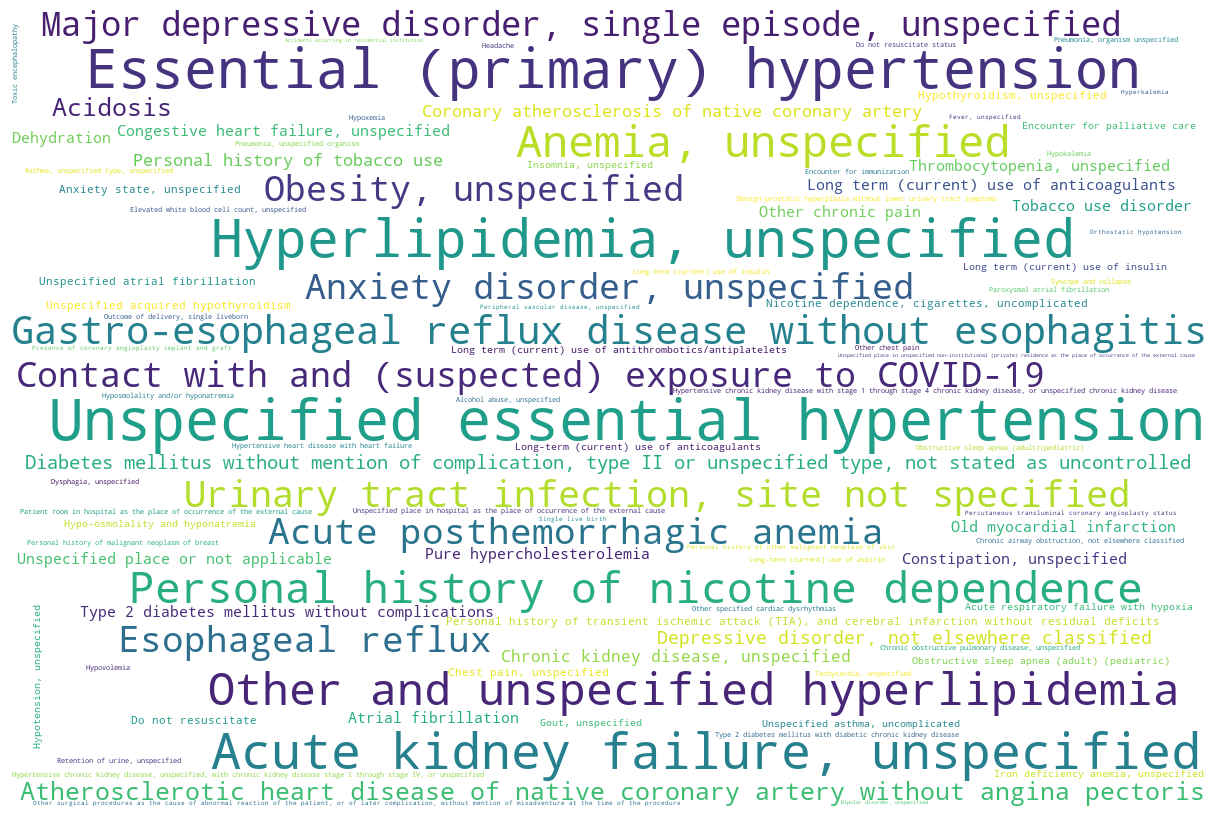

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary for the word cloud
word_freq = {}
for index, row in sorted_icdcode_frequencies_w_def.iterrows():
    title = row['long_title']
    count = row['counts']
    word_freq[title] = word_freq.get(title, 0) + count

# Customize the WordCloud
wordcloud = WordCloud(
    width=1200,           # Higher resolution
    height=800,
    background_color='white',  # Professional clean background
    colormap='viridis',   # Professional color palette
    prefer_horizontal=0.9,  # Mostly horizontal layout
    max_words=100,        # Limit number of displayed titles
    contour_width=1,      # Add a border
    contour_color='black', # Border color
    font_path=None        # You can use a professional font (optional)
).generate_from_frequencies(word_freq)

# Display the WordCloud using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.tight_layout(pad=0)
plt.show()


### Defining Functions



In [15]:
import os
import heapq
from collections import defaultdict

import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from IPython.display import display

# Set pandas options to expand all data within rows
pd.set_option('display.max_columns', None)      
pd.set_option('display.max_colwidth', None) 


def generate_wordcloud(sorted_icdcode_frequencies_w_def, code_desc_column):
    word_freq = {}
    for index, row in sorted_icdcode_frequencies_w_def.iterrows():
        title = row[code_desc_column]
        count = row['counts']
        word_freq[title] = word_freq.get(title, 0) + count
    
    # Customize the WordCloud
    wordcloud = WordCloud(
        width=1200,           # Higher resolution
        height=800,
        background_color='white',  # Professional clean background
        colormap='viridis',   # Professional color palette
        prefer_horizontal=0.9,  # Mostly horizontal layout
        max_words=100,        # Limit number of displayed titles
        contour_width=1,      # Add a border
        contour_color='black', # Border color
        font_path=None        # You can use a professional font (optional)
    ).generate_from_frequencies(word_freq)
    
    # Display the WordCloud using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide axes
    plt.tight_layout(pad=0)
    plt.show()
    return wordcloud



def file_line_count(filepath):
    count = 0
    with open(filepath, 'r') as file:
        for line in file:
            count += 1
    return count



def get_basic_summary(filepath, cols_to_summarize, batch_size):
    
    frequencies = defaultdict(lambda: defaultdict(int))
    non_null_records_count = defaultdict(int)
    total_records_count = 0

    for batch in pd.read_csv(filepath, usecols=cols_to_summarize, chunksize=batch_size, dtype=str):
        total_records_count += len(batch)

        for column in batch.columns:
            # Update non-null record counts using vectorized operation
            non_null_records_count[column] += batch[column].notnull().sum()
    
            # Update frequencies using value_counts (vectorized frequency calculation)
            value_counts = batch[column].value_counts()
            for value, count in value_counts.items():
                frequencies[column][value] += count



    freq_table = [
        (column, len(frequencies[column]), non_null_records_count[column])
        for column in frequencies
    ]


    summary = pd.DataFrame(freq_table, columns=["Column_Name", "Unique_Values", "Non_Null_Records"])
    
    return {'summary':summary,'column_freq':frequencies,'records':total_records_count}

    
def generate_complete_summary(filepath,code_dictionary, patient_id_col, code_cols, cols_to_summarize, code_desc_column, summary_directory, batch_size):
    """
    Generate a comprehensive summary of an EHR dataset, including basic statistics,
    column value frequencies, and patient-code pair counts.
    
    Args:
        filepath (str): Path to the input file.
        patient_id_col (str): Column name representing the patient identifier.
        code_cols (dict): Dictionary specifying code columns (e.g., {'code': 'code_col', 'code_version': 'version_col'}).
        cols_to_summarize (list): List of columns to include in the basic summary.
        summary_directory (str): Directory where summary files will be saved.
        batch_size (int): Number of rows to process in each chunk.
    """
    
    # Extract the base filename without extension
    filename = os.path.splitext(os.path.basename(filepath))[0]
    
    # Generate a basic summary of the dataset
    summarize_output = get_basic_summary(filepath, cols_to_summarize, batch_size)
    total_rows = summarize_output['records']
    print(f"Total Rows in file: {total_rows}")
    
    # Calculate the total number of chunks required
    total_chunks = (total_rows // batch_size) + (1 if total_rows % batch_size > 0 else 0)
    
    # Save the basic summary to a CSV file
    summary_filepath = os.path.join(summary_directory, f"{filename}_basic_summary.csv")
    summarize_output['summary'].to_csv(summary_filepath, index=False)
    
    # Analyze and display top frequencies for each column
    column_frequencies = summarize_output["column_freq"]
    column_frequencies_dfs = []
    for col, freq_data in column_frequencies.items():
        top_frequencies = heapq.nlargest(5, freq_data.items(), key=lambda x: x[1])
        freq_df = pd.DataFrame(top_frequencies, columns=[col, f"{col}_count"])
        column_frequencies_dfs.append(freq_df)
        
    column_frequencies_df = pd.concat(column_frequencies_dfs,axis=1)
    print("Most frequent values under each column:")
    display(column_frequencies_df)
    most_freq_filepath = os.path.join(summary_directory, f"{filename}_most_freq_items.csv")
    column_frequencies_df.to_csv(most_freq_filepath, index=False)
    
    # Determine columns for patient-code pairs processing
    code_columns = [code_cols['code']]
    if 'code_version' in code_cols and code_cols['code_version']:
        code_columns.append(code_cols['code_version'])
    
    columns_to_read = [patient_id_col] + code_columns
    
    # Initialize list to store unique patient-code pairs across chunks
    subject_code_pairs_dfs = []
    
    # Read the dataset in chunks to process patient-code pairs
    chunk_iter = pd.read_csv(filepath, chunksize=batch_size, usecols=columns_to_read, dtype=str)
    for chunk_idx, chunk in enumerate(tqdm(chunk_iter, total=total_chunks, desc="Processing chunks")):
        # Drop duplicates within the current chunk
        unique_pairs = chunk[columns_to_read].drop_duplicates()
        subject_code_pairs_dfs.append(unique_pairs)
    
    # Combine unique pairs from all chunks and remove duplicates
    subject_code_pairs_full = pd.concat(subject_code_pairs_dfs, ignore_index=True).drop_duplicates()
    
    # Count occurrences of each unique code pair and sort by count in descending order
    sorted_code_pairs_counts = (
        subject_code_pairs_full[code_columns]
        .value_counts()
        .reset_index(name='counts')
    )

    sorted_code_freq_and_def = pd.merge(sorted_code_pairs_counts, code_dictionary, on=code_columns, how='left')
    
    display(sorted_code_freq_and_def.head())
    
    sorted_code_freq_and_def.to_csv(os.path.join(summary_directory,f"{filename}_basic_summary.csv"),index=None)
    
    wordcloud = generate_wordcloud(sorted_code_freq_and_def, code_desc_column)

    wordcloud_filepath = os.path.join(summary_directory, f"{filename}_wordcloud.png")
    
    wordcloud.to_file(wordcloud_filepath)

In [17]:
# Initializing folders and file paths

base_directory = os.path.dirname(os.getcwd())
diagnoses_icd_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","diagnoses_icd.csv")
summary_directory = os.path.join(base_directory, 'processed_data', 'Summary')
display(pd.read_csv(diagnoses_icd_file, dtype=str, nrows=5))

d_icd_diagnoses_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","d_icd_diagnoses.csv")
data_dictionary_icd = pd.read_csv(d_icd_diagnoses_file,dtype=str)
display(data_dictionary_icd.head())

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


Total Rows in file: 6364488
Most frequent values under each column:


,subject_id,subject_id_count,icd_code,icd_code_count,icd_version,icd_version_count
0,12468016,2396,4019,102368,10,3455747.0
1,18284271,2077,E785,84570,9,2908741.0
2,10577647,1850,I10,83775,NaN,NaN
3,15114531,1840,2724,67293,NaN,NaN
4,11582633,1777,Z87891,62806,NaN,NaN


Processing chunks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.89s/it]


,icd_code,icd_version,counts,long_title
0,4019,9,52360,Unspecified essential hypertension
1,I10,10,48611,Essential (primary) hypertension
2,E785,10,45431,"Hyperlipidemia, unspecified"
3,2724,9,35210,Other and unspecified hyperlipidemia
4,Z87891,10,32523,Personal history of nicotine dependence


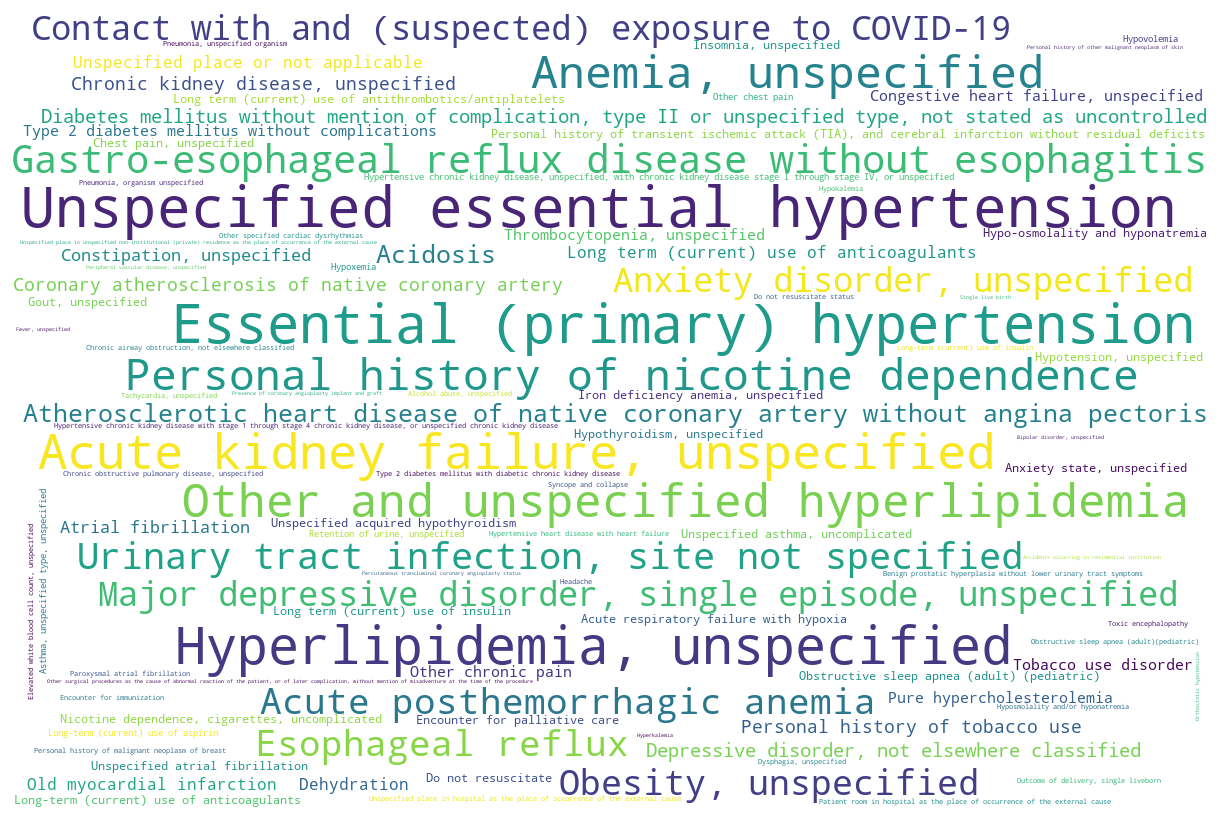

In [18]:
generate_complete_summary(
    diagnoses_icd_file, 
    data_dictionary_icd,
    patient_id_col = "subject_id",
    code_cols= {"code": "icd_code", "code_version":"icd_version"},
    cols_to_summarize=["subject_id","icd_code","icd_version"],
    code_desc_column ="long_title",
    summary_directory=summary_directory,
    batch_size=5000000
)

In [19]:
base_directory = os.path.dirname(os.getcwd())
hcpcsevents_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","hcpcsevents.csv")
summary_directory = os.path.join(base_directory, 'processed_data', 'Summary')
display(pd.read_csv(hcpcsevents_file,dtype=str, nrows=5))

d_hcpcsevents_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp", "d_hcpcs.csv")
data_dictionary_hcpcs = pd.read_csv(d_hcpcsevents_file,dtype=str)
display(data_dictionary_hcpcs.head())

# We need to have the same column names for code to perform the join operation
data_dictionary_hcpcs=data_dictionary_hcpcs.rename(columns={"code":"hcpcs_cd"})
display(data_dictionary_hcpcs.head())

,subject_id,hadm_id,chartdate,hcpcs_cd,seq_num,short_description
0,10000068,25022803,2160-03-04,99218,1,Hospital observation services
1,10000084,29888819,2160-12-28,G0378,1,Hospital observation per hr
2,10000108,27250926,2163-09-27,99219,1,Hospital observation services
3,10000117,22927623,2181-11-15,43239,1,Digestive system
4,10000117,22927623,2181-11-15,G0378,2,Hospital observation per hr


,code,category,long_description,short_description
0,00000,NaN,NaN,Invalid Code
1,0001F,2,NaN,Composite measures
2,0002F,2,NaN,Composite measures
3,0003F,2,NaN,Composite measures
4,0004F,2,NaN,Composite measures


,hcpcs_cd,category,long_description,short_description
0,00000,NaN,NaN,Invalid Code
1,0001F,2,NaN,Composite measures
2,0002F,2,NaN,Composite measures
3,0003F,2,NaN,Composite measures
4,0004F,2,NaN,Composite measures


Total Rows in file: 186074
Most frequent values under each column:


,subject_id,subject_id_count,chartdate,chartdate_count,hcpcs_cd,hcpcs_cd_count
0,15496609,227,2179-03-13,32,G0378,68571
1,15464144,185,2183-11-19,28,99219,52408
2,10714009,150,2173-11-02,28,99218,12091
3,15229574,127,2177-08-16,28,99220,11069
4,14394983,125,2179-07-07,27,44970,1174


Processing chunks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.16it/s]


,hcpcs_cd,counts,category,long_description,short_description
0,G0378,39829,NaN,"Hospital observation service, per hour",Hospital observation per hr
1,99219,39387,1,NaN,Hospital observation services
2,99218,10458,1,NaN,Hospital observation services
3,99220,8354,1,NaN,Hospital observation services
4,44970,1174,1,NaN,Digestive system


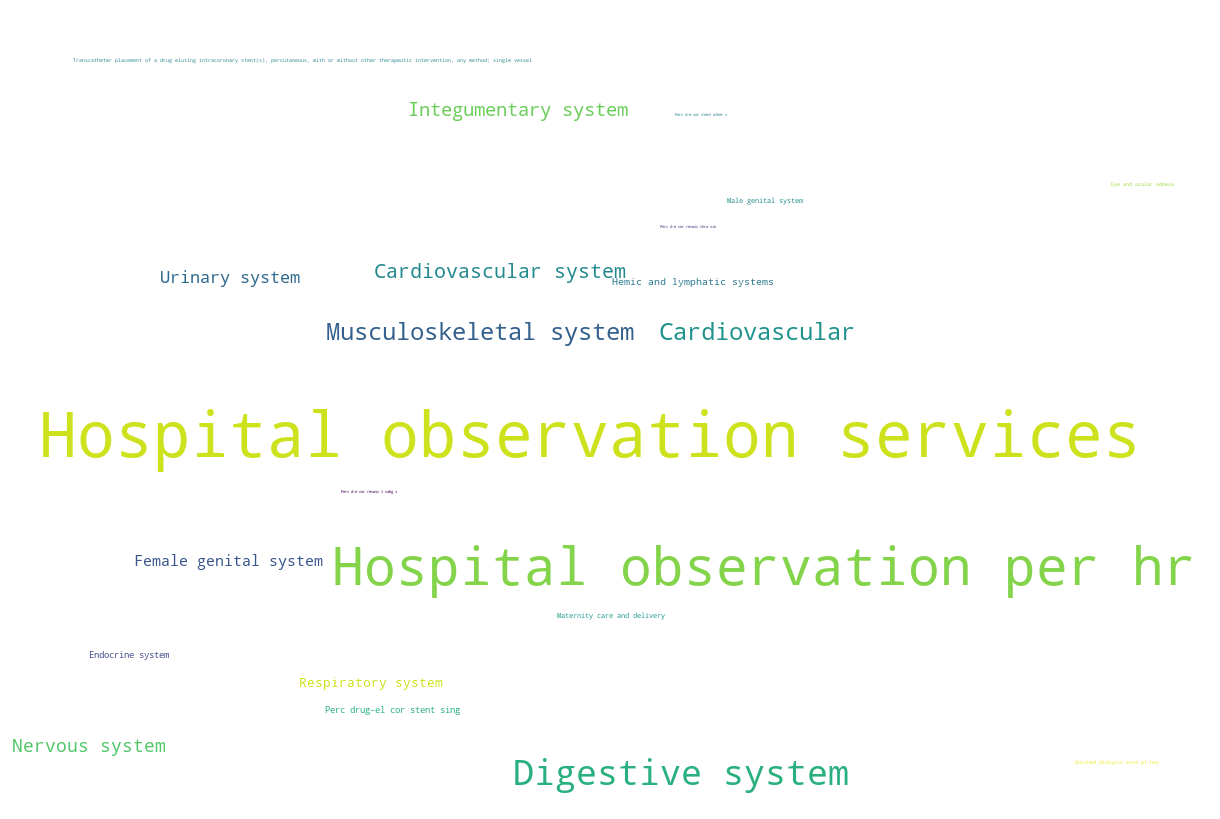

In [20]:
generate_complete_summary(
    hcpcsevents_file, 
    data_dictionary_hcpcs,
    patient_id_col = "subject_id",
    code_cols= {"code": "hcpcs_cd"},
    cols_to_summarize=["subject_id","hcpcs_cd","chartdate"],
    code_desc_column = "short_description",
    summary_directory=summary_directory,
    batch_size=5000000
)

In [21]:
base_directory = os.path.dirname(os.getcwd())
procedures_icd_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","procedures_icd.csv")
summary_directory = os.path.join(base_directory, 'processed_data', 'Summary')
display(pd.read_csv(procedures_icd_file,dtype=str, nrows=5))

d_icd_procedure_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp", "d_icd_procedures.csv")
d_icd_procedure = pd.read_csv(d_icd_procedure_file,dtype=str)
display(d_icd_procedure .head())

,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version
0,10000032,22595853,1,2180-05-07,5491,9
1,10000032,22841357,1,2180-06-27,5491,9
2,10000032,25742920,1,2180-08-06,5491,9
3,10000068,25022803,1,2160-03-03,8938,9
4,10000117,27988844,1,2183-09-19,0QS734Z,10


,icd_code,icd_version,long_title
0,0001,9,Therapeutic ultrasound of vessels of head and neck
1,0002,9,Therapeutic ultrasound of heart
2,0003,9,Therapeutic ultrasound of peripheral vascular vessels
3,0009,9,Other therapeutic ultrasound
4,001,10,"Central Nervous System and Cranial Nerves, Bypass"


Total Rows in file: 859655
Most frequent values under each column:


,subject_id,subject_id_count,icd_code,icd_code_count,icd_version,icd_version_count
0,17295976,350,3893,14644,9,469209.0
1,19530208,199,02HV33Z,14353,10,390446.0
2,13475033,174,8938,10519,NaN,NaN
3,14873669,157,3897,10347,NaN,NaN
4,18553055,148,8856,9549,NaN,NaN


Processing chunks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


,icd_code,icd_version,counts,long_title
0,02HV33Z,10,11227,"Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach"
1,3893,9,10159,"Venous catheterization, not elsewhere classified"
2,8938,9,8807,Other nonoperative respiratory measurements
3,8856,9,7861,Coronary arteriography using two catheters
4,3897,9,7385,Central venous catheter placement with guidance


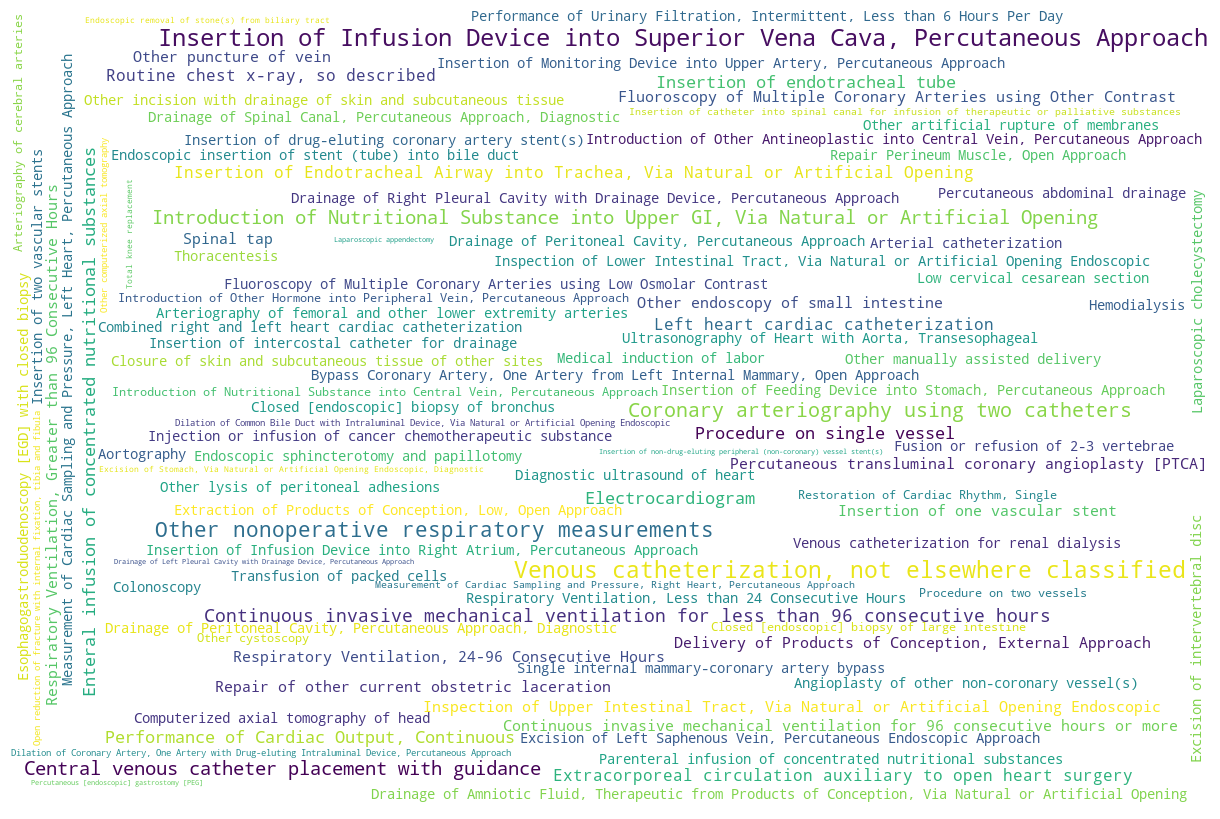

In [22]:
generate_complete_summary(
    procedures_icd_file, 
    d_icd_procedure,
    patient_id_col = "subject_id",
    code_cols= {"code": "icd_code", "code_version":"icd_version"},
    cols_to_summarize=["subject_id","icd_code","icd_version"],
    summary_directory=summary_directory,
    code_desc_column="long_title",
    batch_size=5000000
)

In [23]:
base_directory = os.path.dirname(os.getcwd())
prescriptions_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","prescriptions.csv")
summary_directory = os.path.join(base_directory, 'processed_data', 'Summary')
display(pd.read_csv(prescriptions_file,dtype=str, nrows=5))

d_prescription = pd.read_csv(prescriptions_file,dtype=str, usecols=['ndc','drug'])
d_prescription.drop_duplicates(subset=['ndc'],keep='first',inplace=True)
display(d_prescription)

,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,order_provider_id,starttime,stoptime,drug_type,drug,formulary_drug_cd,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10000032,22595853,12775705,10000032-55,55,P85UQ1,2180-05-08 08:00:00,2180-05-07 22:00:00,MAIN,Furosemide,FURO40,008209,51079007320,40mg Tablet,NaN,40,mg,1,TAB,1,PO/NG
1,10000032,22595853,18415984,10000032-42,42,P23SJA,2180-05-07 02:00:00,2180-05-07 22:00:00,MAIN,Ipratropium Bromide Neb,IPRA2H,021700,00487980125,2.5mL Vial,NaN,1,NEB,1,VIAL,4,IH
2,10000032,22595853,23637373,10000032-35,35,P23SJA,2180-05-07 01:00:00,2180-05-07 09:00:00,MAIN,Furosemide,FURO20,008208,51079007220,20mg Tablet,NaN,20,mg,1,TAB,1,PO/NG
3,10000032,22595853,26862314,10000032-41,41,P23SJA,2180-05-07 01:00:00,2180-05-07 01:00:00,MAIN,Potassium Chloride,MICROK10,001275,00245004101,10mEq ER Tablet,NaN,40,mEq,4,TAB,1,PO
4,10000032,22595853,30740602,10000032-27,27,P23SJA,2180-05-07 00:00:00,2180-05-07 22:00:00,MAIN,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0,10 mL Syringe,NaN,3,mL,0.3,SYR,3,IV


,drug,ndc
0,Furosemide,51079007320
1,Ipratropium Bromide Neb,00487980125
2,Furosemide,51079007220
3,Potassium Chloride,00245004101
4,Sodium Chloride 0.9% Flush,0
...,...,...
20148201,diclofenac sodium,00115148361
20163079,Droperidol,00074118701
20180104,Flovent HFA,00173071820
20223809,Chromium Chloride,00409409301


Total Rows in file: 20292611
Most frequent values under each column:


,subject_id,subject_id_count,drug,drug_count,ndc,ndc_count
0,12468016,8269,Insulin,845166,0,2518625
1,10913302,5769,0.9% Sodium Chloride,728089,00338004904,384236
2,11389314,5552,Potassium Chloride,674552,63323026201,316791
3,10577647,5397,Sodium Chloride 0.9% Flush,673380,00338011704,292265
4,12294892,5302,Acetaminophen,586860,00409672924,227783


Processing chunks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.12s/it]


,ndc,counts,drug
0,0,188786,Sodium Chloride 0.9% Flush
1,63323026201,112309,Heparin
2,00904224461,100746,Docusate Sodium
3,00338011704,97663,Lactated Ringers
4,00338004904,91143,Sodium Chloride 0.9%


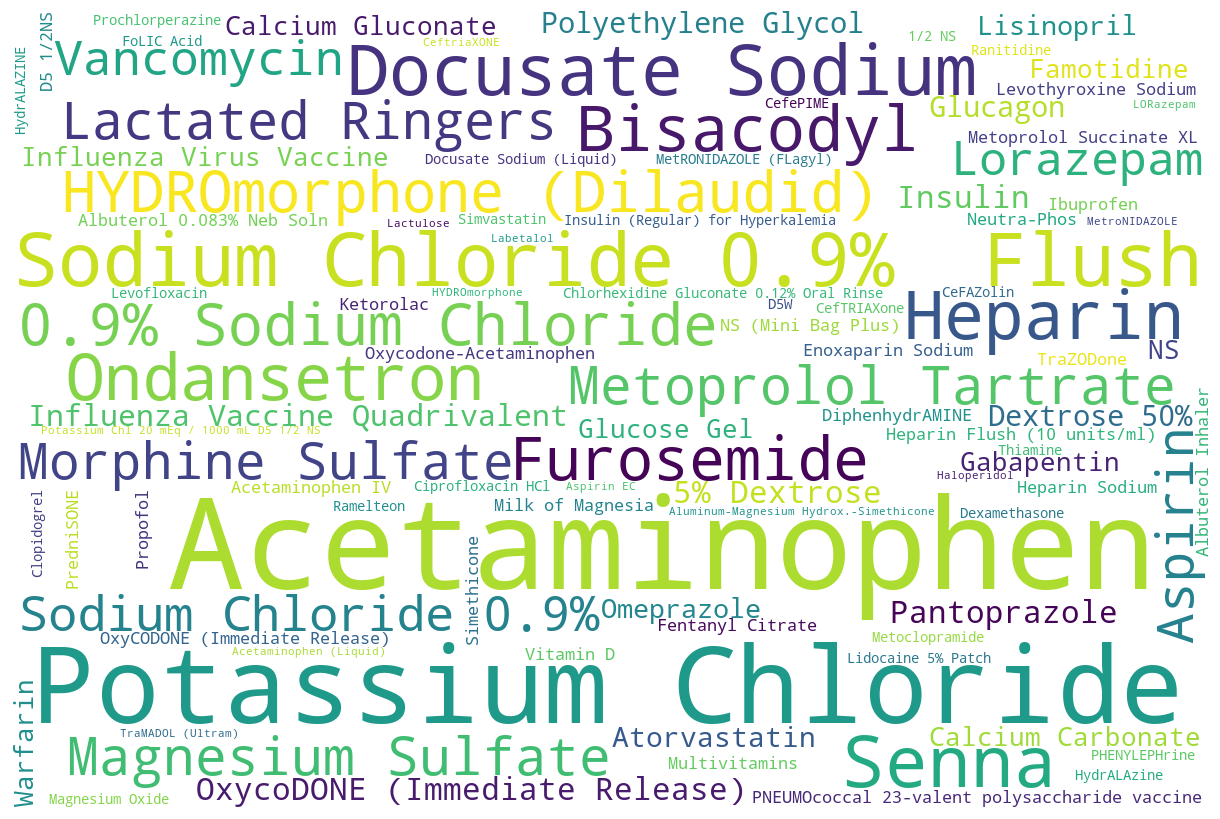

In [24]:
generate_complete_summary(
    prescriptions_file, 
    d_prescription,
    patient_id_col = "subject_id",
    code_cols= {"code": "ndc"},
    cols_to_summarize=["subject_id","ndc","drug"],
    summary_directory=summary_directory,
    code_desc_column="drug",
    batch_size=5000000
)

In [4]:
base_directory = os.path.dirname(os.getcwd())
labitems_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp", "labevents.csv")
summary_directory = os.path.join(base_directory, 'processed_data', 'Summary')
display(pd.read_csv(labitems_file,dtype=str, nrows=5))

d_labitems_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp", "d_labitems.csv")
d_labitems = pd.read_csv(d_labitems_file,dtype=str)
display(d_labitems.head())


,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,1,10000032,NaN,2704548,50931,P69FQC,2180-03-23 11:51:00,2180-03-23 15:56:00,___,95,mg/dL,70,100,NaN,ROUTINE,"IF FASTING, 70-100 NORMAL, >125 PROVISIONAL DIABETES."
1,2,10000032,NaN,36092842,51071,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN
2,3,10000032,NaN,36092842,51074,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN
3,4,10000032,NaN,36092842,51075,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,"BENZODIAZEPINE IMMUNOASSAY SCREEN DOES NOT DETECT SOME DRUGS,;INCLUDING LORAZEPAM, CLONAZEPAM, AND FLUNITRAZEPAM."
4,5,10000032,NaN,36092842,51079,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN


,itemid,label,fluid,category
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas
1,50802,Base Excess,Blood,Blood Gas
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
3,50804,Calculated Total CO2,Blood,Blood Gas
4,50805,Carboxyhemoglobin,Blood,Blood Gas


Total Rows in file: 158374764
Most frequent values under each column:


,subject_id,subject_id_count,itemid,itemid_count
0,12468016,44132,51221,4331615
1,13198542,38225,50912,4319091
2,10913302,36568,51265,4214048
3,12294892,36175,51006,4202807
4,18904293,33869,51222,4181121


Processing chunks: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:54<00:00, 10.40s/it]


,itemid,counts,label,fluid,category
0,51221,298904,Hematocrit,Blood,Hematology
1,51265,298654,Platelet Count,Blood,Hematology
2,51222,298632,Hemoglobin,Blood,Hematology
3,51301,298581,White Blood Cells,Blood,Hematology
4,51279,298570,Red Blood Cells,Blood,Hematology


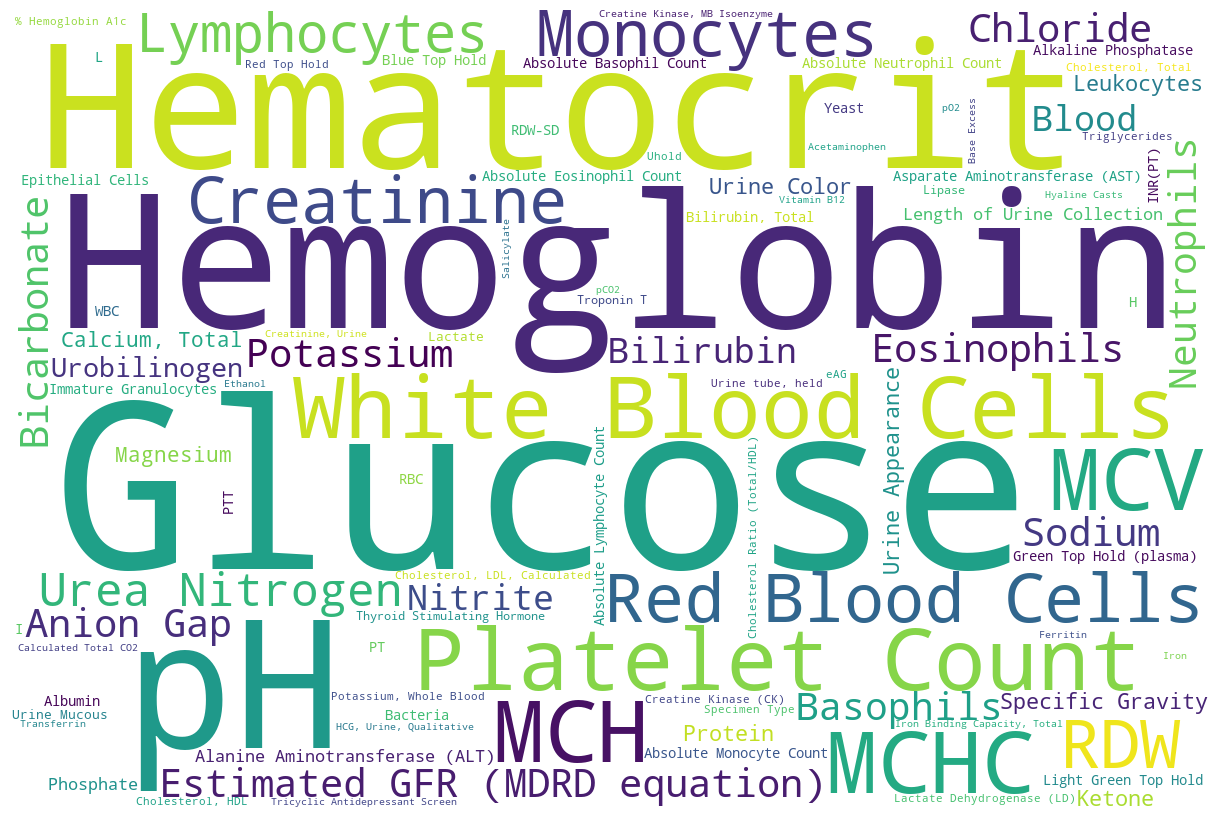

In [5]:
generate_complete_summary(
    labitems_file, 
    d_labitems,
    patient_id_col = "subject_id",
    code_cols= {"code": "itemid"},
    cols_to_summarize=["subject_id","itemid"],
    summary_directory=summary_directory,
    code_desc_column="label",
    batch_size=15000000
)